<a href="https://colab.research.google.com/github/alessandropequeno/PPGEEC-Deep-Learning-UFRN/blob/main/Quest%C3%A3o_1_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Considere o problema das espirais. Sendo a espiral 1 uma classe e a espiral 2 outra classe. Gere os dados usando as seguintes equações: para espiral 1: x = Θ/4 cosΘ :. y = Θ/4 senΘ :. Θ ≥ 0

para espiral 2: x = (Θ/4 + 0.8) cosΘ :. y = (Θ/4 + 0.8) senΘ :. Θ ≥ 0

fazendo Θ assumir 1000 valores igualmente espaçados entre 0 e 20 radianos. Solucione este problema considerando:

b) Um comitê de máquina formado por uma rede perceptron de uma camada oculta, uma
RBF e uma máquina de vetor de suporte (SVM)

### Implementando as Bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim

### gerando os dados

In [3]:
theta = np.linspace(0, 20, 1000)
X_spiral1 = np.column_stack([theta / 4 * np.cos(theta), theta / 4 * np.sin(theta)])
X_spiral2 = np.column_stack([((theta / 4) + 0.8) * np.cos(theta), ((theta / 4) + 0.8) * np.sin(theta)])
X = np.vstack([X_spiral1, X_spiral2])
y = np.hstack([np.zeros(len(X_spiral1)), np.ones(len(X_spiral2))])

### Padronizando os dados e dividindo em treino e teste

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Implementar a Rede Neural com Função de Base Radial (RBF)

In [5]:
class RBFNet(BaseEstimator, ClassifierMixin):
    def __init__(self, num_centers=10, gamma=1.0):
        self.num_centers = num_centers
        self.gamma = gamma

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_centers)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        distances = euclidean_distances(X, self.centers)
        self.std_dev = np.std(distances)
        phi = np.exp(-1 * (distances / self.std_dev) ** 2)
        self.weights = np.linalg.lstsq(phi, y)[0]

    def predict(self, X):
        distances = euclidean_distances(X, self.centers)
        phi = np.exp(-1 * (distances / self.std_dev) ** 2)
        return np.dot(phi, self.weights)

### Treinar o modelo RBF

In [6]:
rbf_model = RBFNet()
rbf_model.fit(X_train, y_train)

# Implementar a Máquina de Vetor de Suporte (SVM)
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='scale'))
svm_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-5-fc1b50c3c8cd>:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.weights = np.linalg.lstsq(phi, y)[0]


Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

### Implementar a Rede Perceptron de uma Camada Oculta

In [7]:
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.activation(self.fc2(x))
        return x

    def fit(self, X, y, epochs=1000, lr=0.01):
        criterion = nn.BCELoss()
        optimizer = optim.SGD(self.parameters(), lr=lr)

        X_torch = torch.tensor(X, dtype=torch.float32)
        y_torch = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

        train_losses = []

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self(X_torch)
            loss = criterion(outputs, y_torch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            print(f"Epoch {epoch}: Loss {loss.item()}")

        plt.plot(train_losses)
        plt.title("Training Loss - Perceptron")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def predict(self, X):
        X_torch = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self(X_torch)
        return outputs.numpy().flatten()

### Treinar a Rede Perceptron de uma Camada Oculta

Epoch 0: Loss 0.7179182171821594
Epoch 1: Loss 0.7177337408065796
Epoch 2: Loss 0.7175508141517639
Epoch 3: Loss 0.7173693776130676
Epoch 4: Loss 0.7171894907951355
Epoch 5: Loss 0.717011034488678
Epoch 6: Loss 0.7168339490890503
Epoch 7: Loss 0.7166584134101868
Epoch 8: Loss 0.7164843678474426
Epoch 9: Loss 0.7163116335868835
Epoch 10: Loss 0.7161403894424438
Epoch 11: Loss 0.7159703969955444
Epoch 12: Loss 0.7158019542694092
Epoch 13: Loss 0.7156347036361694
Epoch 14: Loss 0.7154688835144043
Epoch 15: Loss 0.715304434299469
Epoch 16: Loss 0.715141236782074
Epoch 17: Loss 0.7149794101715088
Epoch 18: Loss 0.7148187756538391
Epoch 19: Loss 0.7146595120429993
Epoch 20: Loss 0.7145014405250549
Epoch 21: Loss 0.7143445014953613
Epoch 22: Loss 0.7141889333724976
Epoch 23: Loss 0.7140344977378845
Epoch 24: Loss 0.713881254196167
Epoch 25: Loss 0.7137292623519897
Epoch 26: Loss 0.713578462600708
Epoch 27: Loss 0.7134287357330322
Epoch 28: Loss 0.7132800817489624
Epoch 29: Loss 0.713132619857

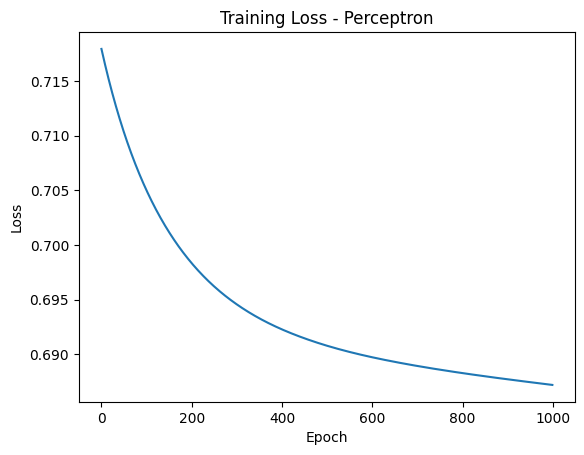

Accuracy - RBF Network: 0.4025
Accuracy - Perceptron: 0.6075
Accuracy - SVM: 0.56


In [8]:
perceptron_model = Perceptron()
perceptron_model.fit(X_train, y_train)

# Avaliar o desempenho de cada modelo
y_pred_rbf = rbf_model.predict(X_test)
y_pred_perceptron = perceptron_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

print("Accuracy - RBF Network:", accuracy_score(y_test, y_pred_rbf.round().astype(int)))
print("Accuracy - Perceptron:", accuracy_score(y_test, y_pred_perceptron.round().astype(int)))
print("Accuracy - SVM:", accuracy_score(y_test, y_pred_svm.round().astype(int)))


### Criar o comitê de máquinas


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-5-fc1b50c3c8cd>:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.weights = np.linalg.lstsq(phi, y)[0]


Epoch 0: Loss 0.6872106194496155
Epoch 1: Loss 0.6872055530548096
Epoch 2: Loss 0.6872006058692932
Epoch 3: Loss 0.6871955990791321
Epoch 4: Loss 0.6871905326843262
Epoch 5: Loss 0.687185525894165
Epoch 6: Loss 0.6871804594993591
Epoch 7: Loss 0.687175452709198
Epoch 8: Loss 0.6871703863143921
Epoch 9: Loss 0.6871654391288757
Epoch 10: Loss 0.6871604919433594
Epoch 11: Loss 0.6871554851531982
Epoch 12: Loss 0.6871504783630371
Epoch 13: Loss 0.687145471572876
Epoch 14: Loss 0.6871405243873596
Epoch 15: Loss 0.6871355175971985
Epoch 16: Loss 0.6871305108070374
Epoch 17: Loss 0.6871254444122314
Epoch 18: Loss 0.6871204376220703
Epoch 19: Loss 0.6871155500411987
Epoch 20: Loss 0.6871105432510376
Epoch 21: Loss 0.687105655670166
Epoch 22: Loss 0.6871005892753601
Epoch 23: Loss 0.6870956420898438
Epoch 24: Loss 0.6870906352996826
Epoch 25: Loss 0.6870856285095215
Epoch 26: Loss 0.6870806813240051
Epoch 27: Loss 0.6870757341384888
Epoch 28: Loss 0.6870707869529724
Epoch 29: Loss 0.68706583976

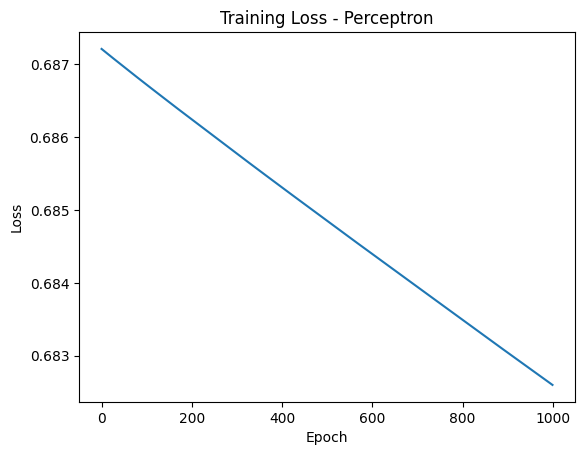

In [9]:
class CommitteeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        for model in self.models:
            if hasattr(model, "fit"):
                model.fit(X, y)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.models)))
        for idx, model in enumerate(self.models):
            predictions[:, idx] = model.predict(X)
        return np.mean(predictions, axis=1)

committee_models = [rbf_model, perceptron_model, svm_model]
committee = CommitteeClassifier(models=committee_models)
committee.fit(X_train, y_train)

### Avaliando o desempenho do comitê e plotando os gráficos

Accuracy - Committee: 0.56


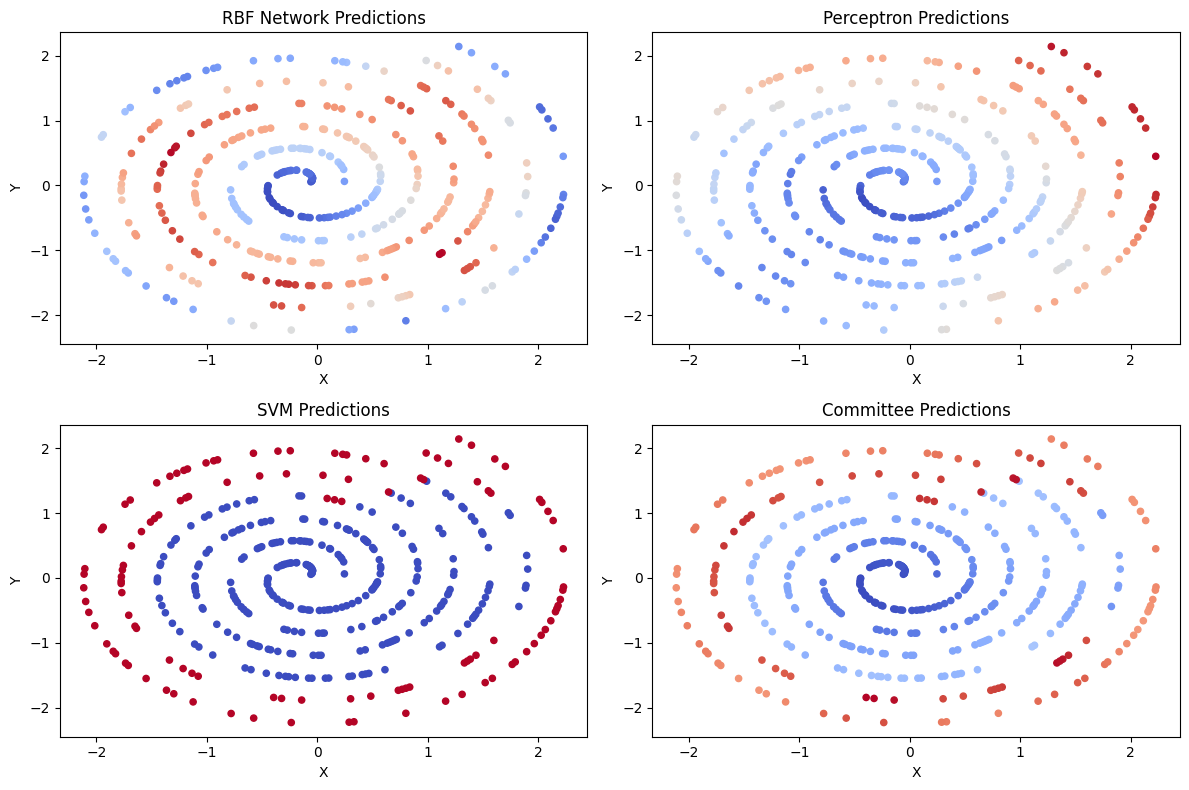

In [10]:
y_pred_committee = committee.predict(X_test)
print("Accuracy - Committee:", accuracy_score(y_test, y_pred_committee.round().astype(int)))

# Plotar os resultados de cada modelo
plt.figure(figsize=(12, 8))

# Plotar as previsões da RBF Network
plt.subplot(2, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_rbf, cmap=plt.cm.coolwarm, s=20)
plt.title("RBF Network Predictions")
plt.xlabel("X")
plt.ylabel("Y")

# Plotar as previsões do Perceptron
plt.subplot(2, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_perceptron, cmap=plt.cm.coolwarm, s=20)
plt.title("Perceptron Predictions")
plt.xlabel("X")
plt.ylabel("Y")

# Plotar as previsões do SVM
plt.subplot(2, 2, 3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_svm, cmap=plt.cm.coolwarm, s=20)
plt.title("SVM Predictions")
plt.xlabel("X")
plt.ylabel("Y")

# Plotar as previsões do comitê
plt.subplot(2, 2, 4)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_committee, cmap=plt.cm.coolwarm, s=20)
plt.title("Committee Predictions")
plt.xlabel("X")
plt.ylabel("Y")

plt.tight_layout()
plt.show()